In [1]:
!pip install plotly
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.0.9-py3-none-any.whl size=184097 sha256=52477e47136c6116a7fd28d58881a13884504da633616c4fb30e3e082647517b
  Stored in directory: /root/.cache/pip/wheels/83/55/6b/552e083cf5509c0afe808b76cf434f1be284d01a112623bd37
Successfully built pyod


In [31]:
import math
import random
import pandas as pd
import numpy as np
import os
import time
import librosa
import librosa.display
import IPython.display as ipd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.colors

from sklearn.ensemble import IsolationForest
from sklearn.decomposition import KernelPCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset

from torch.optim import Optimizer, AdamW
from torch.optim.lr_scheduler import LambdaLR

import joblib
from collections import Counter
import warnings

from pyod.models.deep_svdd import DeepSVDD
from pyod.models.lunar import LUNAR
from sklearn.covariance import EllipticEnvelope

from sklearn.preprocessing import RobustScaler, StandardScaler


warnings.filterwarnings('ignore')

plt.style.use('seaborn-white')

In [70]:
train_df = pd.read_csv("/content/drive/MyDrive/data/dacon/air_press/train_data.csv")
test_df = pd.read_csv("/content/drive/MyDrive/data/dacon/air_press/test_data.csv")
submission =  pd.read_csv("/content/drive/MyDrive/data/dacon/air_press/answer_sample.csv")

In [71]:
train_df

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0
...,...,...,...,...,...,...,...,...
2458,2.28,50.20,0.7,29.53,2416.0,66.84,3.34,7
2459,2.04,46.94,0.7,26.34,2155.0,63.94,3.20,7
2460,1.19,35.74,0.7,15.39,1259.0,53.99,2.70,7
2461,1.21,36.00,0.7,15.64,1280.0,54.22,2.71,7


##### 해당 타입에 맞는 마력을 추가
##### 파생 변수 생성 (전력 소비량, 공기 유속, 공기 유입량/모터 출력)

In [72]:
hp_map = {0: 30, 1: 20, 2: 10, 3: 50, 4: 30, 5: 30, 6: 30, 7: 30}
kW_map = {0: 22, 1: 15, 2: 7.5, 3: 37, 4: 22, 5: 22, 6: 22, 7: 22}

train_df['HP'] = train_df['type'].map(hp_map)
train_df['kW'] = train_df['type'].map(kW_map)
train_df['voltage'] = 380

test_df['HP'] = test_df['type'].map(hp_map)
test_df['kW'] = test_df['type'].map(kW_map)
test_df['voltage'] = 380

def make_feature(df):
    df['power_consumption'] = df['voltage'] * df['motor_current'] * np.sqrt(3) / 1000  # 전력 소비량
    df['out_flow'] = df['out_pressure'] * df['air_inflow'] / df['air_end_temp']  # 공기 유속
    df['air_flow_per_current'] = df['air_inflow'] / df['motor_current']

    return df

In [73]:
train_df = make_feature(train_df)
test_df = make_feature(test_df)

##### train과 test의 각 컬럼들의 이상치를 확인해보았을 때, 몇몇 컬럼을 제외하고는 전체적으로 비슷한 모습을 나타낸다.

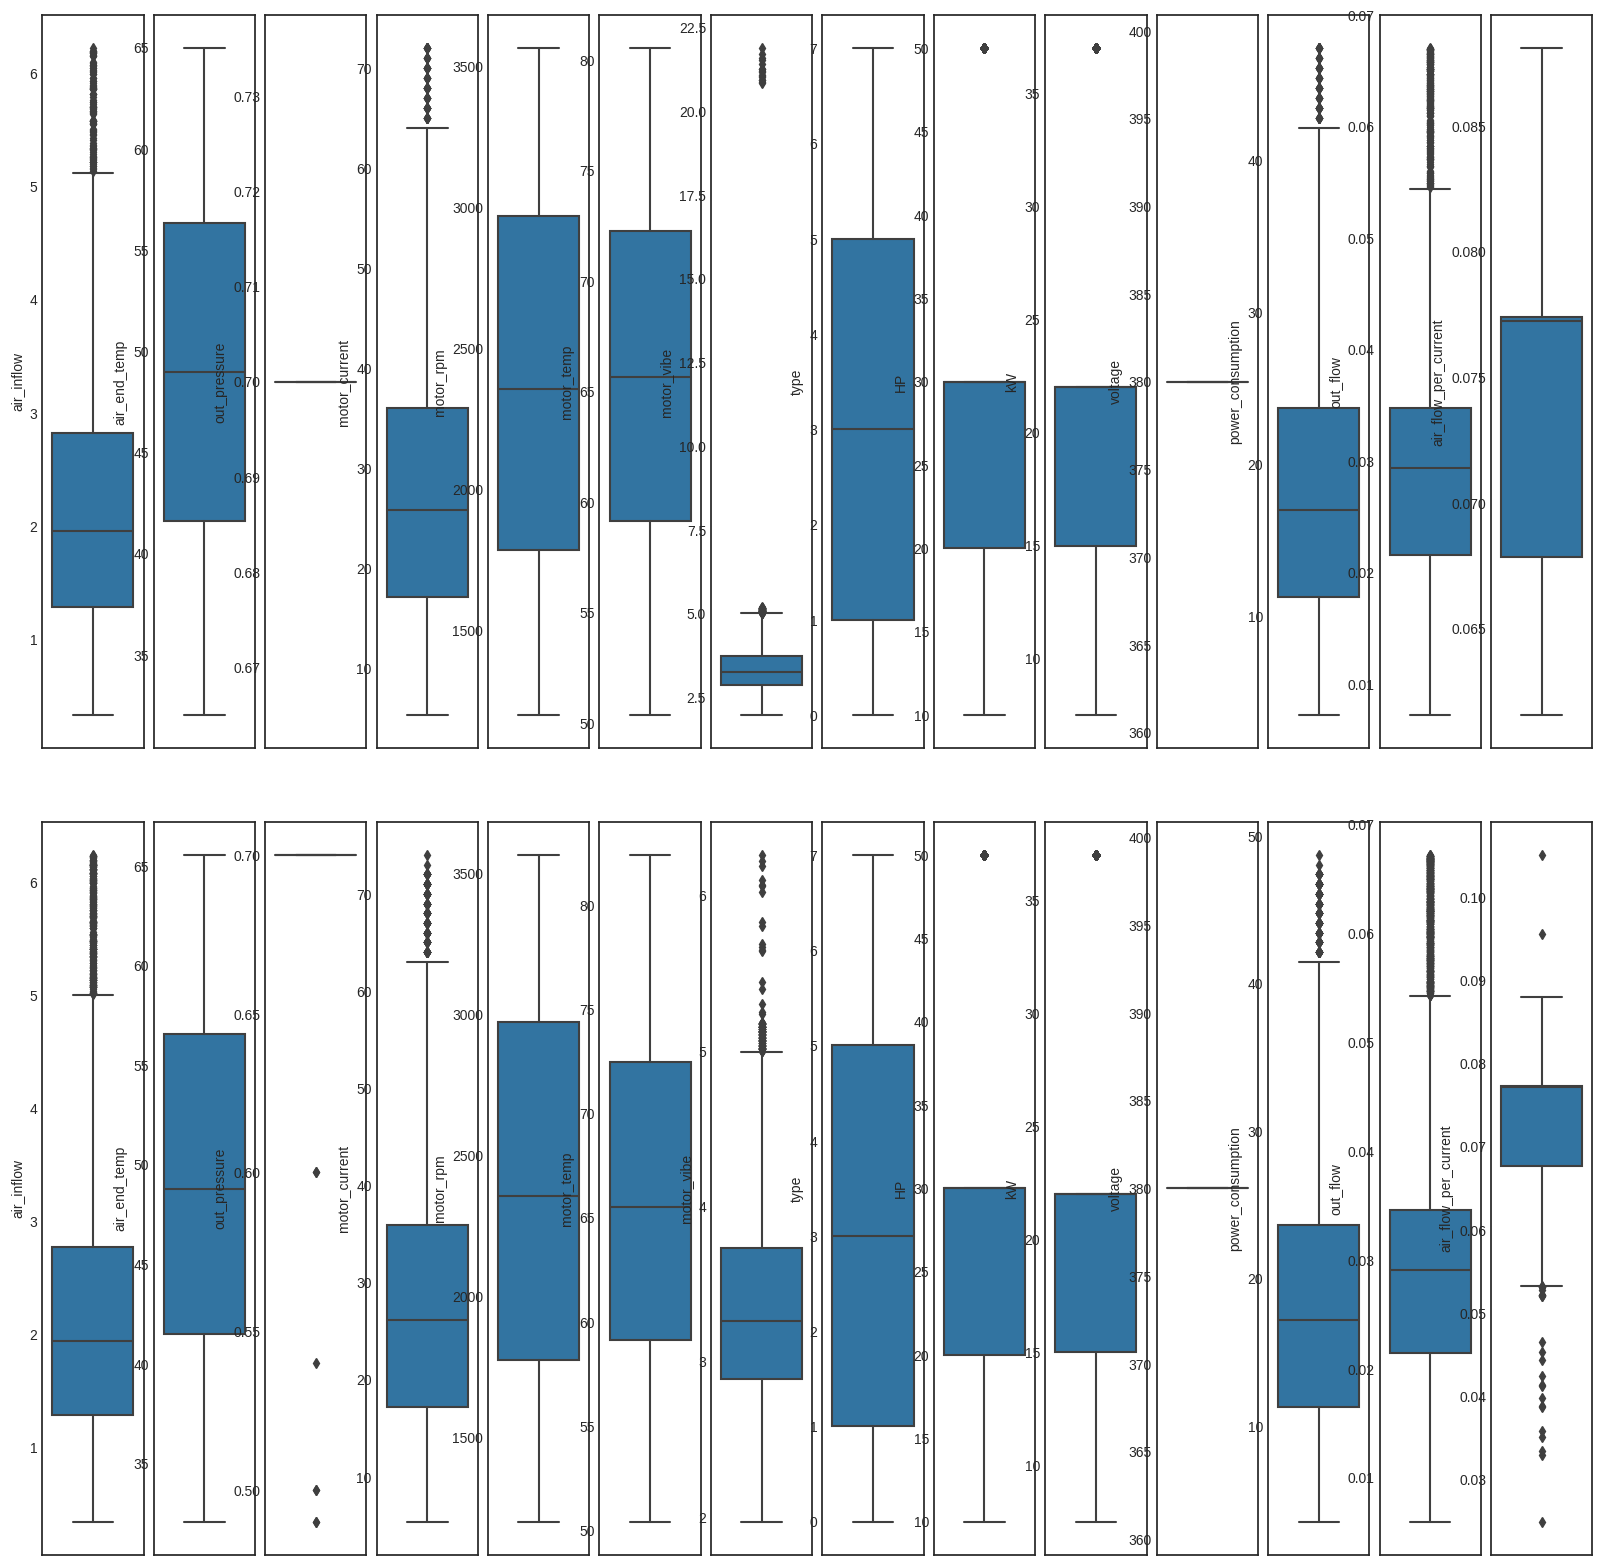

In [74]:
fig, axes = plt.subplots(nrows=2, ncols=len(train_df.columns), figsize=(20, 20))

for i, column in enumerate(train_df.columns):
    sns.boxplot(y=train_df[column], ax=axes[0, i], orient="v")
    axes[0, i].set_ylabel(column)

for i, column in enumerate(test_df.columns):
    sns.boxplot(y=test_df[column], ax=axes[1, i], orient="v")
    axes[1, i].set_ylabel(column)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()

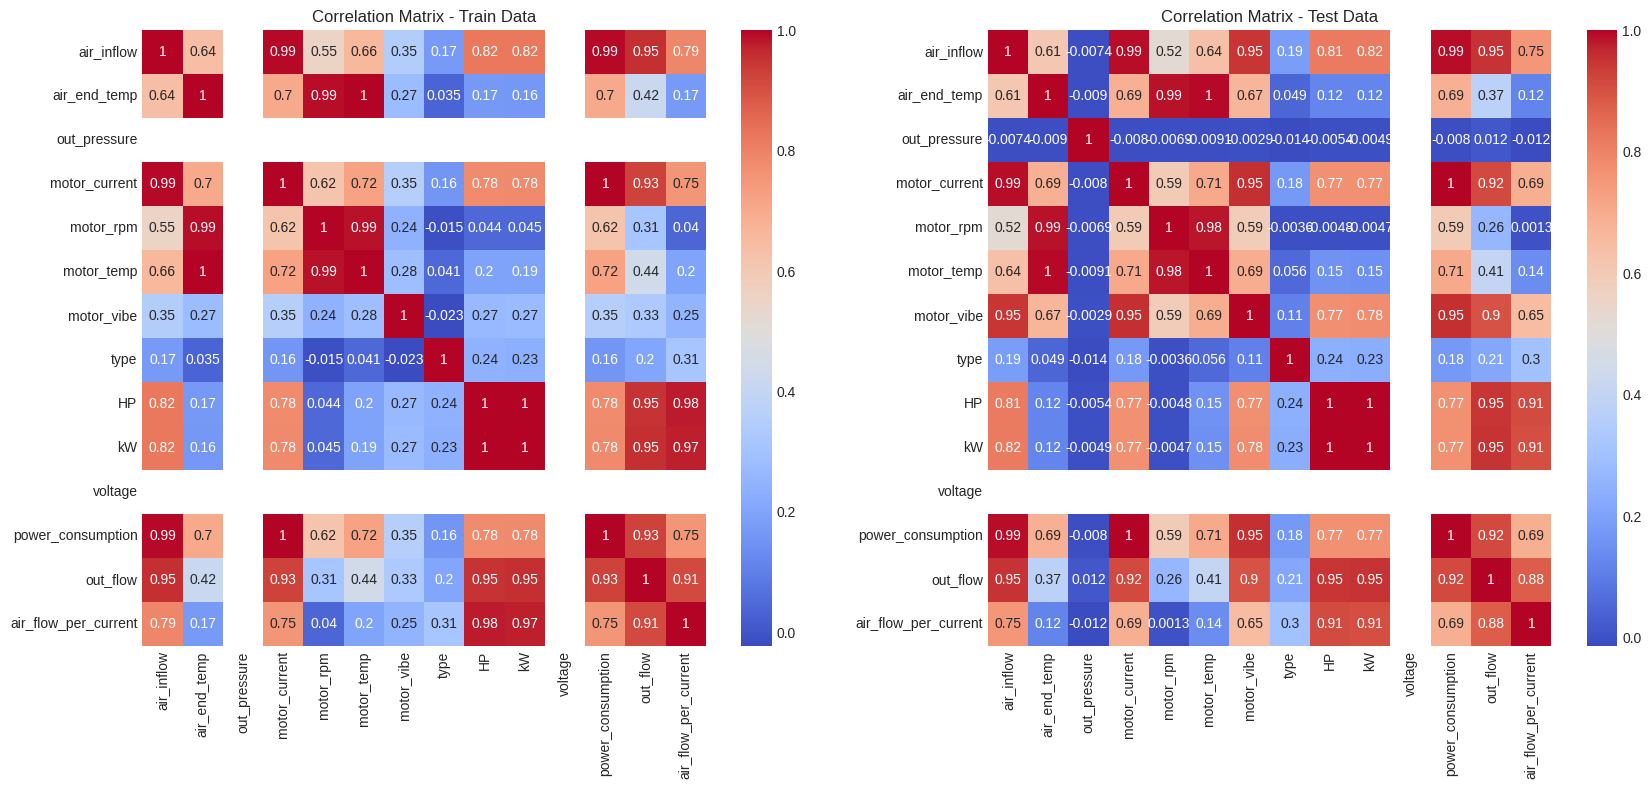

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Correlation Matrix - Train Data')

sns.heatmap(test_df.corr(), annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Correlation Matrix - Test Data')
plt.show()

##### 불필요하다느낀 피쳐들은 제거 후 스케일링 진행

In [76]:
train_df = train_df.drop(['out_pressure', 'HP', 'motor_vibe', 'voltage', 'kW'], axis = 1)
test_df = test_df.drop(['out_pressure', 'HP', 'motor_vibe', 'voltage', 'kW'], axis = 1)

train_type = train_df[['type']]
train_df = train_df.drop(['type'], axis = 1)

test_type = test_df[['type']]
test_df = test_df.drop(['type'], axis = 1)

scaler = scaler = StandardScaler()
train_scaler = scaler.fit_transform(train_df)
test_scaler = scaler.transform(test_df)

train_df = pd.DataFrame(train_scaler, columns=train_df.columns)
test_df = pd.DataFrame(test_scaler, columns=test_df.columns)

In [77]:
train_df = pd.concat([train_df, train_type], axis = 1)
test_df = pd.concat([test_df, test_type], axis = 1)

##### type별로 이상탐지 진행

In [79]:
def divide_type(num):
    train = train_df[train_df['type'] == num].drop(['type'], axis=1)
    test = test_df[test_df['type'] == num].drop(['type'], axis=1)
    return train, test

train_0, test_0 = divide_type(0)
train_1, test_1 = divide_type(1)
train_2, test_2 = divide_type(2)
train_3, test_3 = divide_type(3)
train_4, test_4 = divide_type(4)
train_5, test_5 = divide_type(5)
train_6, test_6 = divide_type(6)
train_7, test_7 = divide_type(7)

##### PCA로 3차원 시각화 후 LOF 알고리즘으로 이상치 확인

##### LOF를 사용한 이유: train과 test의 컬럼들의 분포가 비슷하다고 판단 -> 주변 이웃(밀도)를 고려하는 LOF 선정

In [81]:
def plot_outliers(train, test, y_pred):
    kernel_pca = KernelPCA(
        n_components=3, kernel="rbf", gamma=4, alpha=0.1
    )

    kernel_pca.fit(train)
    pca_transformed = kernel_pca.transform(test)

    fig = go.Figure()
    fig.add_trace(go.Scatter3d(
        x=pca_transformed[:, 0], y=pca_transformed[:, 1], z=pca_transformed[:, 2],
        mode='markers',
        marker=dict(
            color=y_pred,
            colorscale=[[0, 'blue'], [1, 'red']],
            size=2
        )
    ))

    fig.update_layout(scene=dict(
        xaxis_title='PCA Component 1',
        yaxis_title='PCA Component 2',
        zaxis_title='PCA Component 3'
    ), title='Outlier Detection')

    fig.show()

In [82]:
def LOF_outlier_detection(train, test, n_neighbor):
    # LOF 모델 생성
    lof = LocalOutlierFactor(n_neighbors = n_neighbor, novelty = True)
    y_pred = lof.fit(train)
    y_pred = lof.predict(test)

    y_pred = np.where(y_pred == 1, 0, y_pred)
    y_pred = np.where(y_pred == -1, 1, y_pred)
    
    outlier_mask = y_pred == 1

    # 이상치 비율 출력
    outlier_fraction = np.count_nonzero(outlier_mask) / len(outlier_mask)
    print('이상치 비율:', outlier_fraction * 100)

    plot_outliers(train, test, y_pred)
    outlier_indices = np.where(outlier_mask)[0]
    return y_pred, outlier_indices

In [16]:
train = train_df.drop(['type'], axis = 1)
test = test_df.drop(['type'], axis = 1)

In [17]:
pred_0, outlier_0 = LOF_outlier_detection(train_0, test_0, 20)

이상치 비율: 11.033950617283951


In [18]:
pred_1, outlier_1 = LOF_outlier_detection(train_1, test_1, 20)

이상치 비율: 0.0


In [19]:
pred_2, outlier_2 = LOF_outlier_detection(train_2, test_2, 20)

이상치 비율: 2.3679417122040074


In [20]:
pred_3, outlier_3 = LOF_outlier_detection(train_3, test_3, 20)

이상치 비율: 2.832244008714597


In [21]:
pred_4, outlier_4 = LOF_outlier_detection(train_4, test_4, 20)

이상치 비율: 1.4161220043572984


In [22]:
pred_5, outlier_5 = LOF_outlier_detection(train_5, test_5, 20)

이상치 비율: 4.016064257028113


In [23]:
pred_6, outlier_6 = LOF_outlier_detection(train_6, test_6, 20)

이상치 비율: 13.520749665327978


In [24]:
pred_7, outlier_7 = LOF_outlier_detection(train_7, test_7, 20)

이상치 비율: 0.7168458781362007


In [25]:
total_outliers = 0

for i in range(8):
    n_outliers = len(globals()[f"outlier_{i}"])
    total_outliers += n_outliers
    print(f"outlier_{i}: {n_outliers}")
print("total outliers:", total_outliers)

outlier_0: 143
outlier_1: 0
outlier_2: 26
outlier_3: 26
outlier_4: 13
outlier_5: 30
outlier_6: 101
outlier_7: 4
total outliers: 343


In [26]:
pred_all = np.concatenate((pred_0, pred_1, pred_2, pred_3, pred_4, pred_5, pred_6, pred_7)).astype(int)

submission['label'] = pred_all
submission['label'].value_counts()
submission.to_csv('./LOF_343.csv', index = False)